# Titanic Survival - Logistic Regression

Overview: A logistic regression is a simple way to quickly classify observations and provides a predictions for Titanic survivors that are fairly accurate. One major flaw seen with this model is that our top features have an exaggerated weight and skew our results.

In this notebook, we explore the data and clean it best we can. This will involve replacing missing values and converting categorical variables to nominal values so they can be inputted into our model. Afterwards, we will fit logisitic regression models and choose the best combination of features to further analyze. Finally we will create a .csv file to be submitted to the competition and view our final score.

In [1]:
# imports to work with dataframes and arrays as well as to help standardizing, modelling, and visualizing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
#Work inside Kaggle directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Exploring the data

In [4]:
# Import our csv files
kaggle_train = pd.read_csv('/kaggle/input/titanic/train.csv')
kaggle_test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
#Add the missing Survived column to the test dataset so that it can be joined with the training dataset for preprocessing
kaggle_test['Survived'] = np.nan
onethru11 = np.arange(1, 11)
kaggle_test_colOrderadj = [0, 11, 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
kaggle_test = kaggle_test.iloc[:, kaggle_test_colOrderadj]

#Combine rows of train and test csvs for preprocessing
combine_dfs = [kaggle_train, kaggle_test]
titanic = pd.concat(combine_dfs)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


It seems we have some preprocessing work to do, a few columns are missing values, a few columns need to be dropped, and classifier features will need to have values converted to 0s and 1s.

# Preprocessing

A quick summary of the preprocessing that was done:
* Name feature will be dropped as it is an index performing a similar function as our PassengerID.
* Ticket feature groups passengers together, most likely by family if tickets were purchased for multiple people. This feature can be used to determine how many people each customer was traveling with, a simliar but slightly different meaning than SibSp or Parch which measure how many relatives were on-board. Replace this feature with a new feature named "GroupSize" that represents this property of Ticket and hope that it adds meaning to our model.
* Fare is likely strongly associated with the class of the ticket purchased. Currently the issue with this feature is that the dollar value listed is the Total Fare that was paid by all passengers traveling by this Ticket. Will replace this feature with a more standarized version: "FarePerPassenger" which conveys information on how much was paid per passenger. Should be strongly correlated with Pclass(the class of the passenger) Also is missing a value, which will be filled in with the median FarePerPassenger 
* Cabin will be dropped since it is missing too many values(only 22.9% of passengers have a Cabin listed), in an ideal world with complete Cabin data, we would measure whether prefixes such as 'A' or 'C' would group passengers into different sections of the Titanic that would impact their ability to escape the sinking ship.
* Pclass, SibSp, Parch, Embarked, and Sex are categorical variables that will be grouped and values remapped to integer 0s and 1s for modelling
    **note Embarked is missing 2 values, replaced those with 0(the mode)*

## Address the missing Fare value

In [7]:
#Display the missing value
titanic[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


This passenger is traveling 3rd class so we will find the median 3rd class FarePerPassenger and assume that value for this passenger.

In [8]:
#Exploring the Ticket feature for duplicate values
print(titanic.groupby('Ticket')['Name'].nunique())

Ticket
110152         3
110413         3
110465         2
110469         1
110489         1
              ..
W./C. 6608     5
W./C. 6609     1
W.E.P. 5734    2
W/C 14208      1
WE/P 5735      2
Name: Name, Length: 929, dtype: int64


In [9]:
#Viewing examples of duplicate values in Ticket feature
titanic[titanic['Ticket'] == 'W./C. 6608']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,1,3,W./C. 6608,34.375,NaN,S
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,2,2,W./C. 6608,34.375,NaN,S
436,437,0.0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.375,NaN,S
736,737,0.0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,NaN,S
167,1059,NaN,3,"Ford, Mr. Edward Watson",male,18.0,2,2,W./C. 6608,34.375,NaN,S


In [10]:
#Add new features GroupSize and FarePerPassenger
titanic['GroupSize'] = titanic.groupby('Ticket')['Ticket'].transform('count')
titanic['FarePerPassenger'] = titanic['Fare']/titanic['GroupSize']

In [11]:
#Substitute the median value of 3rd class tickets for our missing Fare value under the new FarePerPassenger feature
titanic.loc[titanic.PassengerId == 1044, 'FarePerPassenger'] = titanic[titanic['Pclass'] == 3]['FarePerPassenger'].median()
titanic[titanic['PassengerId'] == 1044]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,GroupSize,FarePerPassenger
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,7.75


Standardizing the Fare for each passenger into our new feature FarePerPassenger allowed us to further define our clusters for Pclass: 3rd class paid roughly 7-8 dollars per passenger, 2nd class about 10-15 dollars, and 1st class between roughly 23-45 dollars

In [12]:
titanic.columns.values
first_drop_remaining = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
       'Parch', 'Embarked', 'GroupSize', 'FarePerPassenger']
titanic = titanic[first_drop_remaining]

In [13]:
#Convert Embarked and Sex features into integers to be compatible with sklearn LogisitcRegression
# 0 = embarked from Southampton port
# 1 = embarked from Cherbourg or Queenstown port
titanic['Embarked'] = titanic['Embarked'].map({'S':0, 'C':1, 'Q':1})
titanic['Embarked'] = titanic['Embarked'].fillna(0)
titanic['Embarked'] = titanic['Embarked'].astype('int')

# 0 = Male
# 1 = Female
titanic['Sex'] = titanic['Sex'].map({'male':0, 'female':1})

In [14]:
#View the dataset after our first round of Preprocessing
titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,GroupSize,FarePerPassenger
0,1,0.0,3,0,22.0,1,0,0,1,7.250000
1,2,1.0,1,1,38.0,1,0,1,2,35.641650
2,3,1.0,3,1,26.0,0,0,0,1,7.925000
3,4,1.0,1,1,35.0,1,0,0,2,26.550000
4,5,0.0,3,0,35.0,0,0,0,1,8.050000
...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,0,NaN,0,0,0,1,8.050000
414,1306,NaN,1,1,39.0,0,0,1,3,36.300000
415,1307,NaN,3,0,38.5,0,0,0,1,7.250000
416,1308,NaN,3,0,NaN,0,0,0,1,8.050000


# Predicting Age for missing values

Age is currently missing some of its values and a simple strategy can be taken to input values for those that are missing so that this feature can be used in our Survival predictions.

Implement a simple Multiple Imputation by Chained Equations(MICE) process, which creates linear regressions to predict missing values. This is done by
1. First splitting the dataset into two datasets, one that includes values where the Age is known and the other which contains missing Age values.
2. Then a linear regression model is created with our known Age dataset by using Age values as the dependent variable and the other features as independent variables.
3. Finally the model is used to predict unknown Age values.

Another possible solution to this includes using KNearestNeightbours(KNN) from sklearn

In [15]:
#Find the number of missing Age values
titanic['Age'].isnull().sum()

263

In [16]:
#Select the columns needed for modelling, excluding Survival
target_array_wAge = [4, 0, 2, 3, 5, 6, 7, 8, 9]
targets_wAge = titanic.iloc[:,target_array_wAge]

#Create our training datset to only include those that have an Age value
age_train = targets_wAge[targets_wAge.Age.notnull()]
age_train.shape

(1046, 9)

In [17]:
#Create our training datset to only include those that are missing Age values
age_test = targets_wAge[targets_wAge.Age.isnull()]

#Create two testing dataset, one to predict missing Age values and the other to match PassengerIds to
test_x_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked', 'GroupSize', 'FarePerPassenger']
test_x_predict_cols = ['PassengerId','Pclass', 'Sex', 'SibSp', 'Parch','Embarked', 'GroupSize', 'FarePerPassenger']
age_test_x = age_test[test_x_cols]
age_test_x_predicted = age_test[test_x_predict_cols]

age_test_x.shape

(263, 7)

Split the train dataset into x inputs and y target columns. Target is the Age column

In [18]:
#Inputs(x)
train_input_cols = ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked', 'GroupSize', 'FarePerPassenger']
age_train_inputs = age_train[train_input_cols]

#Target(y)
age_train_target_cols = ['Age']
age_train_y = age_train[age_train_target_cols]

Create a Standard Scaler object from scikit package to scale the inputs of our training inputs

In [19]:
sscaler = StandardScaler()
sscaler.fit(age_train_inputs)
train_age_scaled_x = sscaler.transform(age_train_inputs)

Create the Linear Regression model for predicting Age based on our training inputs.

In [20]:
#Fit and score a Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(train_age_scaled_x, age_train_y)
lin_reg.score(train_age_scaled_x, age_train_y)

0.24719255529345885

Scoring our Linear model's ability to predict Age, it appears the model is highly inaccurate. Regardless, continuing to use this model for predicting Age will provide more variance than simply using a statistical mean, median, or mode to assume values. 

Next, add the predictions created from the linear model to our original dataset to replace missing values.

In [21]:
#Add predictions to our Age column
age_test_x_predicted['Age_predictions'] = lin_reg.predict(age_test_x)
age_test_x_predicted = age_test_x_predicted.iloc[:,[0,8]]
age_test_x_predicted

,PassengerId,Age_predictions
5,6,30.322248
17,18,45.166802
19,20,26.417603
26,27,27.731117
28,29,27.792060
...,...,...
408,1300,27.459266
410,1302,27.520614
413,1305,29.984742
416,1308,29.984742


In [22]:
#Merge these predictions onto our original dataset
titanic_age_predicted = pd.merge(titanic, age_test_x_predicted, on='PassengerId', how='left')

In [23]:
#Replace Age values with Age_predictions if they were null
for i in range(len(titanic_age_predicted['Age'])):
    if np.isnan(titanic_age_predicted['Age'][i]):
        insert_age = titanic_age_predicted['Age_predictions'][i]
        titanic_age_predicted['Age'][i] = insert_age

In [24]:
#Display amount of missing Age Values
np.isnan(titanic_age_predicted['Age']).sum()

0

Sure enough, no more missing values are displayed in the Age column

In [25]:
#Drop the temporary predictions for Age as we have already replaced our missing Age values with predicted Age values
titanic_age_predicted = titanic_age_predicted.drop(['Age_predictions'], axis = 1)

# Splitting back into training and testing datasets

Now that our preprocessing is complete, we will reseparate the datasets back into train and test datasets based on whether Survival is known or not.

In [26]:
#Separate back into our train and test datasets
titanic_train = titanic_age_predicted[titanic_age_predicted.Survived.notnull()]
titanic_test = titanic_age_predicted[titanic_age_predicted.Survived.isnull()]

Decided to select an in-between selection of features. Features with Coefficeints near 0 and Odds Ratios near 1 were removed but not those that were only slightly impactful.

First model created was overfit, only 9 Passengers in our test dataset were shown to survive.
The features Parch, Embarked, GroupSize, and FarePerPassenger had a Coefficient near 0 and an Odds Ratio near 1 when fitting a Logistic Regression model.

Our third model was underfit and lowered the score on our model, this model took only the top 2 features that were most influential to our model(Sex and Pclass) and dropped all other variables.


* Coefficient shows the feature's general impact on our model, a Coefficient near 0 only overfits a model and can be roughly interepted to mean the p value is too high.
* Odds Ratio represents a multipler associated with how likely survival is, an Odds Ratio of x for a feature means that the for each 1 increase in that feature's value there is an x times higher likelihood of survival. An Odds Ratio near 1 only means that there is very little change in survival likelihood for each change in the feature.

In [27]:
#Chose to move forwards with the training features in titanic_train_x1 and disregard titanic_train_x and titanic_train_x2
#Split our datasets into x an y inputs, x representing the training features and y representing the target(Survival) to use in our model

titanic_train_x = titanic_train.loc[:,['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'GroupSize', 'FarePerPassenger']]
titanic_train_x1 = titanic_train.loc[:, ['Pclass', 'Sex', 'Age', 'SibSp']]
titanic_train_x2 = titanic_train.loc[:, ['Pclass', 'Sex']]
titanic_train_y = titanic_train.loc[:, ['Survived']]


titanic_train_y['Survived'] = titanic_train_y['Survived'].astype('int')
titanic_train_y = titanic_train_y[['Survived']].to_numpy()
titanic_train_y = np.ravel(titanic_train_y)

In [28]:
#Chose to move forwards with the training features in titanic_test_x1 and disregard titanic_test_x and titanic_test_x2
#The test dataset will only have an x input to be used to predict our y(Survival)
titanic_test_x = titanic_test.drop(['Survived'], axis = 1)
titanic_test_x1 = titanic_test.drop(['Survived', 'Parch', 'Embarked', 'GroupSize', 'FarePerPassenger'], axis = 1)
titanic_test_x2 = titanic_test.drop(['Survived', 'Parch', 'Embarked', 'GroupSize', 'FarePerPassenger', 'Age', 'SibSp'], axis = 1)
titanic_test_x_noID = titanic_test_x1.drop(['PassengerId'], axis = 1)
titanic_test_x_noID

,Pclass,Sex,Age,SibSp
891,3,0,34.500000,0
892,3,1,47.000000,1
893,2,0,62.000000,0
894,3,0,27.000000,0
895,3,1,22.000000,1
...,...,...,...,...
1304,3,0,29.984742,0
1305,1,1,39.000000,0
1306,3,0,38.500000,0
1307,3,0,29.984742,0


# Standarizing our inputs

In [29]:
#Use our StandardScaler method from earlier(used when preparing our data for predicting Age)
#Scale both the training and testing x datasets
sscaler.fit(titanic_train_x1)
sscaler.fit(titanic_test_x_noID)

StandardScaler()

In [30]:
#Transform both datasets into a new array that is modelling-friendly
titanic_train_x_scaled = sscaler.transform(titanic_train_x1)
titanic_test_x_scaled = sscaler.transform(titanic_test_x_noID)

# Fitting and Scoring a Logistic Regression

Now that datatypes are converted to numeric form and missing values have been replaced, we can fit our Logistic Regression

In [31]:
#Create a new model object and fit with our training features
titanic_logreg = LogisticRegression()
titanic_logreg.fit(titanic_train_x_scaled, titanic_train_y)
titanic_logreg.score(titanic_train_x_scaled, titanic_train_y)

0.8035914702581369

With a score around 80%, we are correctly predicting the survival of 4 out of 5 passengers. This is a good spot to be in.

# Evaluating features

As mentioned earlier, we initially modelled with all the features given as well as the features GroupSize and FarePerPassenger, which were calculated from our Ticket and Fare features as a replacement with more standardized values.
This seems to have been a valient attempt to add meaning to our Ticket and Fare columns but the features GroupSize and FarePerPassenger were ultimately scraped due to their low impact on our logisitc model(Coefficient near 0 and Odds Ratio near 1)

Similarly, we also dropped Parch and Embarked as it had almost no impact on our model.

In [32]:
#Create a summary table that displays Coefficients
feature_name = titanic_train_x1.columns.values
logreg_summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
logreg_summary_table['Coefficient'] = np.transpose(titanic_logreg.coef_)

#Add our model's Intercept to this summary table
logreg_summary_table.index = logreg_summary_table.index + 1
logreg_summary_table.loc[0] = ['Intercept', titanic_logreg.intercept_[0]]

#Add our Odds Ratio stats as well and sort by the highest Odds Ratio
logreg_summary_table['Odds ratio'] = np.exp(logreg_summary_table.Coefficient)
logreg_summary_table.sort_values('Odds ratio', ascending = False)

,Feature name,Coefficient,Odds ratio
2,Sex,1.304204,3.684756
4,SibSp,-0.320374,0.725877
3,Age,-0.372050,0.689320
0,Intercept,-0.527483,0.590089
1,Pclass,-0.995364,0.369589


It looks like PClass and Sex are shown to have the highest impact on our model. Both have high Coefficients and Odds Ratio. Females are about 3.7 times more likely to survive than males(males were assigned to 0 and females were assigned to 1).

The class ticket that you carried also was a strong indication of your survival likelihood. An Odds Ratio of about 0.37 means that every increase in 1 class(eg. from 1st to 2nd class) drops your survival rate by about three-fold. The negative Coefficient also supports this, a lower Pclass is associated stronger with survival.

Age and SibSp seem to both be negatively correlated with Survival. The more siblings you have and the older you are, the lower your chances of surviving. These features have a lower impact on our model but should still be included.

# Testing the model

In [33]:
#Add predictions for Survival onto our test dataset using the logistic model
titanic_test_x['Survived_pred'] = titanic_logreg.predict(titanic_test_x_scaled)

#Show the survival rate on our test dataset, we are unable to calculate score without the reality of whether our predicts were correct.. yet
titanic_test_x[titanic_test_x['Survived_pred'] == 1].shape[0]/titanic_test_x.shape[0]

0.3803827751196172

In [34]:
#Show the survival rate on the original dataset
titanic[titanic['Survived'] == 1].shape[0]/titanic.shape[0]

0.2612681436210848

Our model after tuning is no longer overfit. Initially the model only predicted 9 survivors out of 418 passengers in our test dataset, a far lower proportion of survivors than on the initial dataset.

Keeping only the Pclass, Sex, Age, and SibSp features allowed for our model to work somewhat well fitting the test dataset, showing that about 38% of passengers would survive, a higher stat than the 26% of passengers surviving on our training dataset.

# Analyzing our Model

Let's take a look at our most influential features, Sex and Pclass, and compare how our model predicts survival rate to what our training dataset tell us about survival.

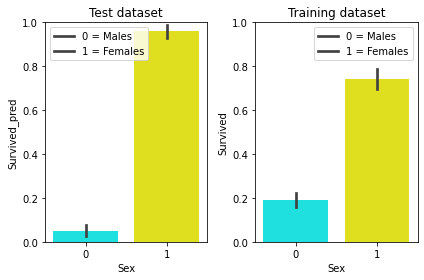

In [35]:
#Plot a bar chart comparing Male and Female survival for both the training and testing datasets
plt.subplot(1, 2, 1)
sns.barplot(x='Sex', y='Survived_pred', data=titanic_test_x,palette=['cyan','yellow'])
plt.legend(['0 = Males', '1 = Females'], loc='top left')
plt.axis([-0.5, 1.5, 0, 1])
plt.title("Test dataset")

plt.subplot(1, 2, 2)
sns.barplot(x='Sex', y='Survived', data=titanic,palette=['cyan','yellow'])
plt.legend(['0 = Males', '1 = Females'], loc='top left')
plt.axis([-0.5, 1.5, 0, 1])
plt.title("Training dataset")
plt.tight_layout()

We can see our model is overpredicting female survival compared to male survival. Let's see if this is explained by our other strong feature, Pclass

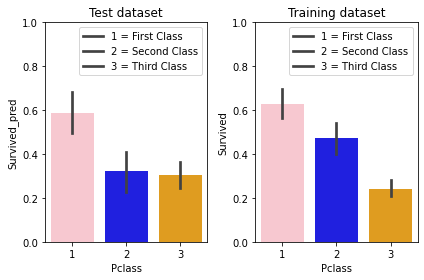

In [36]:
#Plot a bar chart comparing survival between Classes for both the training and testing datasets
plt.subplot(1, 2, 1)
sns.barplot(x='Pclass', y='Survived_pred', data=titanic_test_x,palette=['pink','blue', 'orange'])
plt.legend(['1 = First Class', '2 = Second Class', '3 = Third Class'], loc='top right')
plt.axis([-0.5, 2.5, 0, 1])
plt.title("Test dataset")

plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=titanic,palette=['pink','blue', 'orange'])
plt.legend(['1 = First Class', '2 = Second Class', '3 = Third Class'], loc='top right')
plt.axis([-0.5, 2.5, 0, 1])
plt.title("Training dataset")
plt.tight_layout()

While the predictions for 1st class survival rate was on par with what we saw in our training dataset, our logistic model predicted a higher 3rd class survival rate

Next we will combine these two features to see which has the greater impact

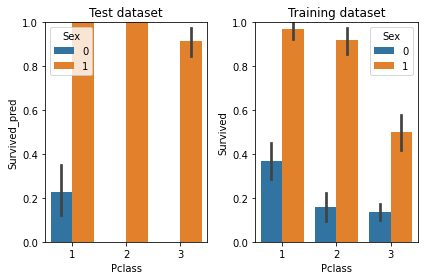

In [37]:
#Plot a bar chart comparing survival between Classes splitting by Sex for both the training and testing datasets
plt.subplot(1, 2, 1)
label = 'Male', 'Female'
sns.barplot(x='Pclass', y='Survived_pred', data=titanic_test_x,hue='Sex')
plt.axis([-0.5, 2.5, 0, 1])
plt.title("Test dataset")

plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=titanic,hue='Sex')
plt.axis([-0.5, 2.5, 0, 1])
plt.title("Training dataset")
plt.tight_layout()

Our model overweights the impact of Sex when determining survival rates: Males are much less likely to not survive in all classes while Female survival was almost guarenteed. Class of the passenger also plays a role but is dramatically overshadowed by Sex. This is not as drastically shown with our original dataset.

Is it possible that there is just an overrepresentation of Females in our test dataset or perhaps a hidden disproportionality between the representation of the classes? Most likely not since our Class comparison on survival rate was relatively comparable between Classes and that graph was dramatically polarized by including Sex into the picture.

We will check anyway and visualize the differences between the test dataset and the training dataset.

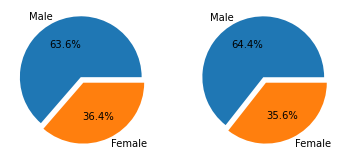

In [38]:
#Create pie charts for the composition ratio of Sex in both the training and testing datasets
sizes_test = [titanic_test_x['Sex'].value_counts()[0], titanic_test_x['Sex'].value_counts()[1]]
sizes_train = [titanic['Sex'].value_counts()[0], titanic['Sex'].value_counts()[1]]
explode = (0.1, 0)
labels = 'Male', 'Female'

plt.subplot(1, 2, 1)
plt.pie(sizes_test, explode=explode, labels=labels, autopct='%1.1f%%')

plt.subplot(1, 2, 2)
plt.pie(sizes_train, explode=explode, labels=labels, autopct='%1.1f%%')
plt.show()

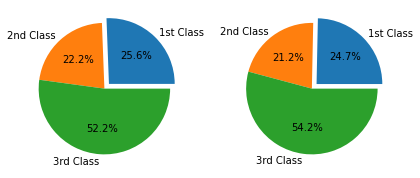

In [39]:
#Create pie charts for the composition ratio of Class in both the training and testing datasets
sizes_test = [titanic_test_x['Pclass'].value_counts()[1], titanic_test_x['Pclass'].value_counts()[2], titanic_test_x['Pclass'].value_counts()[3]]
sizes_train = [titanic['Pclass'].value_counts()[1], titanic['Pclass'].value_counts()[2], titanic['Pclass'].value_counts()[3]]
explode = (0.1, 0, 0)
labels = '1st Class', '2nd Class', '3rd Class'

plt.subplot(1, 2, 1)
plt.pie(sizes_test, explode=explode, labels=labels, autopct='%1.1f%%')

plt.subplot(1, 2, 2)
plt.pie(sizes_train, explode=explode, labels=labels, autopct='%1.1f%%')
plt.tight_layout()

Representation of Sex and Class are approximately equivalent.

Let's briefly look at the minor features, SibSp and Age, in relation to Sex

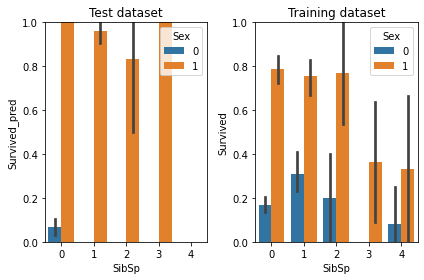

In [40]:
#Plot a bar chart comparing survival depending on number of Siblings are aboard
#and splitting by Sex for both the training and testing datasets
plt.subplot(1, 2, 1)
sns.barplot(x='SibSp', y='Survived_pred', data=titanic_test_x,hue='Sex')
plt.axis([-0.5, 4.5, 0, 1])
plt.title("Test dataset")

plt.subplot(1, 2, 2)
sns.barplot(x='SibSp', y='Survived', data=titanic,hue='Sex')
plt.axis([-0.5, 4.5, 0, 1])
plt.title("Training dataset")
plt.tight_layout()

We are seeing the same pattern as seen between Sex and Class, our model is predicting almost no survival of Males irregardless of the amount of siblings. Our training dataset shows a higher survival rate amongst passengers with less siblings on board for both males and females

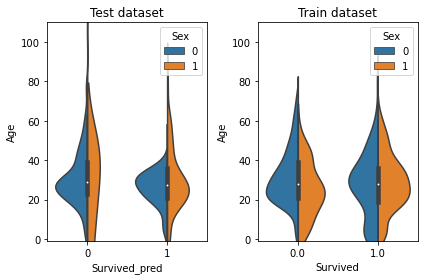

In [41]:
#Plot violin charts comparing the Age of survivors and splitting by Sex for both the training and testing dataset
plt.subplot(1, 2, 1)
sns.violinplot(x='Survived_pred', y='Age', data=titanic_test_x,hue='Sex', split=True)
plt.title('Test dataset')
plt.axis([-0.5, 1.5, -1, 110])

plt.subplot(1, 2, 2)
sns.violinplot(x='Survived', y='Age', data=titanic,hue='Sex', split=True)
plt.title('Train dataset')
plt.axis([-0.5, 1.5, -1, 110])
plt.tight_layout()

While the average ages are approximately matching between datasets, we can see that Male survival is disproportionately lower in our Test dataset. The effect is not as dramatic as our view on Class or SibSp however.

These minor features only support our conclusion that our logistic model disproportionately predicts survival based on Sex compared to our Training dataset.

# Conclusion

A logistic regression model for predicting survival on the Titanic overemphasizes the higher Female survival rate and overall gives a higher survival rate. We saw in our analysis that this flaw in our model could not be explained through variations in the other features used in the model. Although the model fits our training dataset to about 80% accuracy, it would be expected that the test accuracy is much lower because of this major flaw.

Some alternatives that may be a better choice for modelling this Supervised Classification problem could be Kernel SVM, Random Forest,or Gradient Boosting Tree

# Exporting

In [42]:
#Select the columns required for submission and rename to match competition requirements
subm_cols = ['PassengerId', 'Survived_pred']
titanic_test_x_subm = titanic_test_x.loc[:, subm_cols]
titanic_test_x_subm = titanic_test_x_subm.rename(columns={'Survived_pred':'Survived'})

#Output to .csv
titanic_test_x_subm.to_csv('submission.csv', index=False)